<a href="https://colab.research.google.com/github/yangli2/flux-jupyter/blob/main/flux.1-schnell_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %cd /content
# !git clone https://github.com/yangli2/ComfyUI /content/ComfyUI
%cd /content/ComfyUI

# !pip install -q torchsde torch_xla[tpu] einops diffusers accelerate xformers==0.0.28.post2
# !apt -y install -qq aria2

/content/ComfyUI


In [2]:
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/waifu-diffusion/wd-1-5-beta3/resolve/main/wd-illusion-fp16.safetensors -d /content/ComfyUI/models/checkpoints -o wd-illusion-fp16.safetensors


Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
c2cc6d|OK  |   283MiB/s|/content/ComfyUI/models/checkpoints/wd-illusion-fp16.safetensors

Status Legend:
(OK):download completed.


In [2]:
import random
import torch
import torch_xla
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from comfy_extras import nodes_custom_sampler
from comfy import model_management

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


Using XLA device: xla:0
Using XLA device: xla:0


In [3]:
CheckpointLoaderSimple = NODE_CLASS_MAPPINGS["CheckpointLoaderSimple"]()

In [4]:
with torch.inference_mode():
    unet, clip, vae = CheckpointLoaderSimple.load_checkpoint("wd-illusion-fp16.safetensors")


Using XLA device: xla:0
Using XLA device: xla:0
Using XLA device: xla:0
Using XLA device: xla:0
Using XLA device: xla:0


In [9]:
KSampler = NODE_CLASS_MAPPINGS["KSampler"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

In [ ]:
KSampler.sample()

13515353602758848380


  0%|          | 0/20 [00:00<?, ?it/s]

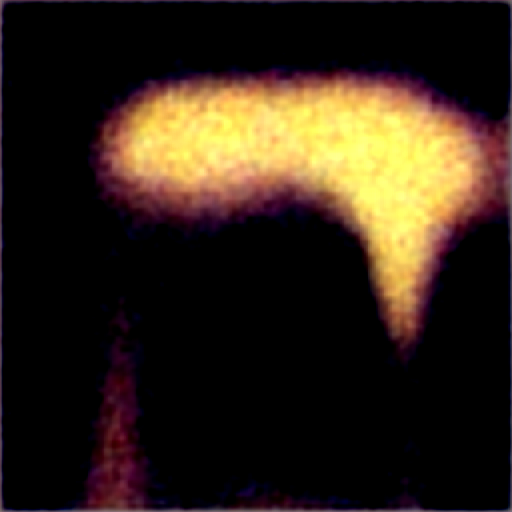

In [26]:
KSampler = NODE_CLASS_MAPPINGS["KSampler"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

torch_xla.experimental.eager_mode(True)

def sample_fn(noise, guider, sampler, sigmas, latent_image):
    return SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
# compiled_sample_fn = torch_xla.compile(sample_fn)

with torch.inference_mode():
    positive_prompt = "Chun-li, a pretty girl in fighting clothes and pantyhose, masturbating hard"
    width = 512
    height = 512
    seed = 0
    steps = 10
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=False)
    cond = [[cond, {}]]
    latent_image = EmptyLatentImage.generate(width, height)[0]
    sample = KSampler.sample(unet, seed=seed, steps=20, cfg=8.0, sampler_name='dpmpp_2m_sde', scheduler='normal', negative=[], positive=cond, latent_image=latent_image)[0]
    torch_xla.sync()
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

In [16]:
print(sample)

({'samples': tensor([[[[ 27.4761,  28.1509,  24.9342,  ...,  30.2151,  22.1496,  17.0590],
          [ 29.6187,  25.6928,  29.4218,  ...,  22.0153,  23.4064,  19.2848],
          [ 31.7208,  25.5439,  27.2205,  ...,  26.2410,  24.5329,  18.2790],
          ...,
          [ 23.0705,  22.0803,  19.7817,  ...,   3.4563,   2.4739,  -0.2718],
          [ 14.0144,  13.7469,  16.4253,  ...,  -0.7839,  -1.4201,  -6.9890],
          [ 10.1426,  10.8829,  10.6247,  ...,  -7.1626,  -6.1099, -14.7073]],

         [[  7.3097,   5.8872,   9.3978,  ...,   1.6581,   3.6727,   6.0974],
          [  2.8297,   0.8452,   2.4259,  ...,  -2.5009,  -2.9299,   6.0699],
          [  3.7019,   2.6857,   3.1800,  ...,  -2.3453,  -2.4150,   3.5042],
          ...,
          [ -7.4653,  -8.0529, -12.1655,  ..., -36.4478, -38.7823, -42.8803],
          [ -5.9171, -14.4939, -14.9954,  ..., -36.4986, -35.2740, -40.8902],
          [ -3.9844,  -9.9524, -17.3563,  ..., -33.9201, -30.9368, -33.4266]],

         [[ -2.10

In [ ]:
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/black-forest-labs/FLUX.1-schnell/resolve/main/flux1-schnell.safetensors -d /content/ComfyUI/models/unet -o flux1-schnell.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/ComfyUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/ComfyUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/ComfyUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import torch_xla
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from comfy_extras import nodes_custom_sampler
from comfy import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-schnell.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

In [ ]:
with torch.inference_mode():
    positive_prompt = "black forest toast spelling out the words 'FLUX DEV', tasty, food photography, dynamic shot"
    width = 1024
    height = 1024
    seed = 0
    steps = 4
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("/content/flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])